In [ ]:
# Install required packages (Colab: this will install into the runtime)
!pip install -q xgboost scikit-learn imbalanced-learn shap matplotlib seaborn pandas openpyxl

# Try to install LIME; if it fails we'll continue and use SHAP-only local explanations.
try:
    !pip install -q lime
    LIME_AVAILABLE = True
except Exception as e:
    print("Could not install lime. Will fallback to SHAP for local explanations.")
    LIME_AVAILABLE = False

In [ ]:
# Imports and global config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")
RANDOM_SEED = 42

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import shap
if LIME_AVAILABLE:
    from lime.lime_tabular import LimeTabularExplainer

In [ ]:
#Download dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
local_path = "/content/default_credit.xls"
if not os.path.exists(local_path):
    os.system(f"wget -q -O {local_path} '{url}'")
# Read excel (header row 1 in this file)
df = pd.read_excel(local_path, header=1)
print("raw shape:", df.shape)
display(df.head())

raw shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
df.rename(columns={'default payment next month':'default'}, inplace=True)
# drop ID if present
if 'ID' in df.columns:
    df.drop(columns=['ID'], inplace=True)
print("after rename shape:", df.shape)
display(df.head())

after rename shape: (30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
# Domain feature engineering
# "engineer at least three domain-relevant features"
# create:
#  - TOTAL_BILL: sum of bill amounts
#  - TOTAL_PAY: sum of pay amounts
#  - PAYMENT_RATIO: TOTAL_PAY / (TOTAL_BILL + 1)
#  - AVG_BILL, AVG_PAY
#  - TOTAL_PAY_DELAY: count of months with PAY_i > 0 (delays)
bill_cols = [c for c in df.columns if c.startswith('BILL_AMT')]
pay_cols = [c for c in df.columns if c.startswith('PAY_AMT')]
pay_status_cols = [c for c in df.columns if c.startswith('PAY_') and c not in pay_cols]  # PAY_0..PAY_6 are status

# Totals and averages
df['TOTAL_BILL'] = df[bill_cols].sum(axis=1)
df['TOTAL_PAY']  = df[pay_cols].sum(axis=1)
df['AVG_BILL']   = df[bill_cols].mean(axis=1)
df['AVG_PAY']    = df[pay_cols].mean(axis=1)

# Payment delay count: count of PAY_0..PAY_6 where value > 0 (positive -> late)
pay_status_names = [c for c in df.columns if c.startswith('PAY_') and c not in pay_cols]
df['TOTAL_PAY_DELAY'] = df[pay_status_names].apply(lambda row: sum(1 for v in row if v > 0), axis=1)

# Installment ratio: monthly installment commitment / credit_amount
if 'installment_commitment' in df.columns:
    df['INSTALL_RATIO'] = df['installment_commitment'] / (df['credit_amount'] + 1)
else:
    # if not available, make safe fallback
    df['INSTALL_RATIO'] = 0.0

# A binary indicator for owning house (if such housing column exists)
if 'housing' in df.columns:
    df['OWN_HOUSE'] = (df['housing'] == df['housing'].mode()[0]).astype(int)
else:
    df['OWN_HOUSE'] = 0

# Check produced features
print("Features after FE:", df[['TOTAL_BILL','TOTAL_PAY','AVG_BILL','AVG_PAY','TOTAL_PAY_DELAY','INSTALL_RATIO','OWN_HOUSE']].head())


Features after FE:    TOTAL_BILL  TOTAL_PAY      AVG_BILL      AVG_PAY  TOTAL_PAY_DELAY  \
0        7704        689   1284.000000   114.833333                2   
1       17077       5000   2846.166667   833.333333                2   
2      101653      11018  16942.166667  1836.333333                0   
3      231334       8388  38555.666667  1398.000000                0   
4      109339      59049  18223.166667  9841.500000                0   

   INSTALL_RATIO  OWN_HOUSE  
0            0.0          0  
1            0.0          0  
2            0.0          0  
3            0.0          0  
4            0.0          0  


In [ ]:
#  Prepare X, y and simple cleaning
# "train an optimized XGBoost model for binary default prediction"
y = df['default'].astype(int)
X = df.drop(columns=['default'])

# If any string columns are present, mark them as categorical; else proceed numeric
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("num_cols:", len(num_cols), "cat_cols:", cat_cols)

num_cols: 30 cat_cols: []


In [ ]:
# ===== Block 6: Train-test split =====
# Maps to Cultus: stable AUC evaluation and reproducibility (stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
print("train/test shapes:", X_train.shape, X_test.shape)


train/test shapes: (24000, 30) (6000, 30)


In [ ]:
# Preprocessing pipeline
# Numeric scaler + OneHotEncoder for categorical columns (sparse=False for compatibility with SHAP/LIME)
from sklearn.impute import SimpleImputer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
if len(cat_cols) > 0:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])
else:
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, num_cols)
    ])

# Fit the preprocessor on X_train and transform both train/test to get processed arrays
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# Recover processed feature names for use in SHAP/LIME
processed_feature_names = []
processed_feature_names += num_cols
if len(cat_cols) > 0:
    # gather one-hot feature names
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    ohe_names = list(ohe.get_feature_names_out(cat_cols))
    processed_feature_names += ohe_names

print("processed shape:", X_train_proc.shape, "num features:", len(processed_feature_names))

processed shape: (24000, 30) num features: 30


In [ ]:
# Balance classes (SMOTE) on training set only =====
#  training robust so model learns minority class
sm = SMOTE(random_state=RANDOM_SEED)
X_train_bal, y_train_bal = sm.fit_resample(X_train_proc, y_train)
print("after SMOTE:", X_train_bal.shape, y_train_bal.shape)
print("class distribution (train bal):\n", pd.Series(y_train_bal).value_counts())

after SMOTE: (37382, 30) (37382,)
class distribution (train bal):
 default
0    18691
1    18691
Name: count, dtype: int64


In [ ]:
#Model & hyperparameter tuning (RandomizedSearchCV)
# "train an optimized XGBoost model" and "report hyperparameter choices"
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED, n_jobs=-1)

param_dist = {
    'n_estimators': [150, 300, 500],
    'max_depth': [3,4,5,6,7],
    'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.5, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.01, 0.1, 1.0]
}

rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# Fit on balanced training data
rs.fit(X_train_bal, y_train_bal)
print("Best params:", rs.best_params_)
best_model = rs.best_estimator_

# Save best model
joblib.dump(best_model, "best_xgb_model.pkl")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.8}


['best_xgb_model.pkl']

In [ ]:
#  Predict and evaluate =====
#  "final performance metrics (AUC, Precision, Recall) reported"
probs = best_model.predict_proba(X_test_proc)[:,1]
y_pred = (probs >= 0.5).astype(int)   # default threshold; you can tune threshold for trade-off

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, probs)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print("Final test metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"AUC:      {auc:.4f}")
print(f"Precision:{prec:.4f}")
print(f"Recall:   {rec:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: threshold tuning to maximize recall or F1 while preserving AUC - simple approach
from sklearn.metrics import f1_score
best_thresh, best_f1 = 0.5, f1_score(y_test, y_pred)
for thr in np.linspace(0.3,0.7,21):
    ythr = (probs >= thr).astype(int)
    f1 = f1_score(y_test, ythr)
    if f1 > best_f1:
        best_f1, best_thresh = f1, thr
print(f"Best threshold by F1: {best_thresh:.2f} -> F1 {best_f1:.4f}")


Final test metrics:
Accuracy: 0.8040
AUC:      0.7585
Precision:0.5794
Recall:   0.4152

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      4673
           1       0.58      0.42      0.48      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.66      0.68      6000
weighted avg       0.79      0.80      0.79      6000

Confusion matrix:
 [[4273  400]
 [ 776  551]]
Best threshold by F1: 0.36 -> F1 0.5150


In [ ]:
#  Global interpretability using SHAP (Top 10 features) =====
# "Apply global interpretability methods (overall SHAP summary plots) to identify top 10 features"
explainer = shap.TreeExplainer(best_model)
# For tree explainer, provide processed matrix (numpy)
shap_values = explainer.shap_values(X_train_proc if isinstance(X_train_proc, np.ndarray) else X_train_proc.toarray())
# Average absolute SHAP
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': processed_feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

top10 = shap_df.head(10)
print("Top 10 features by SHAP:\n", top10)


Top 10 features by SHAP:
             feature  mean_abs_shap
27  TOTAL_PAY_DELAY       0.460023
5             PAY_0       0.395208
0         LIMIT_BAL       0.299617
4               AGE       0.237988
11        BILL_AMT1       0.137060
24        TOTAL_PAY       0.133591
17         PAY_AMT1       0.132649
22         PAY_AMT6       0.120348
18         PAY_AMT2       0.112950
2         EDUCATION       0.103974


In [ ]:
# Local Interpretability for 5 Cases (FP, FN, correct default, correct non-default, borderline)
# "Select five diverse loan applications and generate SHAP local explanations"

import numpy as np
import shap
import matplotlib.pyplot as plt
import os

# 1. Ensure predictions & probabilities exist again
y_true = y_test.values
y_proba = best_model.predict_proba(X_test_proc)[:, 1]
y_pred = (y_proba >= best_thresh).astype(int)

# 2. CASE SELECTION
# ---- FP: predicted 1 but actual 0 ----
cases_fp = np.where((y_true == 0) & (y_pred == 1))[0]

# ---- FN: predicted 0 but actual 1 ----
cases_fn = np.where((y_true == 1) & (y_pred == 0))[0]

# ---- Correct default ----
cases_default = np.where((y_true == 1) & (y_pred == 1))[0]

# ---- Correct non-default ----
cases_non_default = np.where((y_true == 0) & (y_pred == 0))[0]

# ---- Borderline (probability closest to 0.50) ----
border_margin = np.abs(y_proba - 0.50)
cases_borderline = np.argsort(border_margin)[:20]     # top 20 closest
cases_borderline = [cases_borderline[0]]              # choose 1

print("FN:", len(cases_fn),
      "FP:", len(cases_fp),
      "Correct-Default:", len(cases_default),
      "Correct-NonDefault:", len(cases_non_default),
      "Borderline:", len(cases_borderline))

# Final selected 5 cases
selected_cases = []

if len(cases_fn) > 0:
    selected_cases.append(int(np.random.choice(cases_fn)))
if len(cases_fp) > 0:
    selected_cases.append(int(np.random.choice(cases_fp)))
if len(cases_default) > 0:
    selected_cases.append(int(np.random.choice(cases_default)))
if len(cases_non_default) > 0:
    selected_cases.append(int(np.random.choice(cases_non_default)))

selected_cases += cases_borderline
selected_cases = selected_cases[:5]

print("Selected cases:", selected_cases)

# 3. Create output folder
os.makedirs("local_plots", exist_ok=True)

# 4. SHAP explainer for tree models
explainer = shap.TreeExplainer(best_model)

# 5. Generate local SHAP plots
for idx in selected_cases:

    exp = shap.Explanation(
        values = shap_values[idx],
        base_values = explainer.expected_value,
        data = X_test_proc[idx],
        feature_names = processed_feature_names
    )

    plt.tight_layout()
    shap.plots.waterfall(exp, show=False)
    plt.savefig(f"local_plots/shap_local_{idx}.png", dpi=220, bbox_inches="tight")
    plt.clf()

print("✔ Local SHAP plots saved in: local_plots/")


FN: 590 FP: 798 Correct-Default: 737 Correct-NonDefault: 3875 Borderline: 1
Selected cases: [3447, 5610, 5628, 1201, np.int64(3487)]
✔ Local SHAP plots saved in: local_plots/


<Figure size 800x650 with 0 Axes>

In [ ]:
#  Global SHAP Bar Plot
import shap
import matplotlib.pyplot as plt

# Create SHAP Explanation object for global plots
exp_global = shap.Explanation(
    values = shap_values,
    base_values = explainer.expected_value,
    data = X_train_proc,
    feature_names = processed_feature_names
)

plt.figure(figsize=(10,6))
shap.plots.bar(exp_global, max_display=20, show=False)  # show top 20

plt.title("Global Feature Importance (SHAP Bar Plot)")
plt.tight_layout()
plt.savefig("shap_bar_plot.png", dpi=200)
plt.clf()

print("✓ SHAP Bar Plot saved as shap_bar_plot.png")


✓ SHAP Bar Plot saved as shap_bar_plot.png


In [ ]:
# SHAP Summary Plot (Violin)
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values,
                  features=X_train_proc,
                  feature_names=processed_feature_names,
                  show=False)

plt.tight_layout()
plt.savefig("shap_summary_violin.png", dpi=200)
plt.clf()

print("✓ SHAP Summary Violin Plot saved as shap_summary_violin.png")


✓ SHAP Summary Violin Plot saved as shap_summary_violin.png


In [ ]:
# Local SHAP Plots
import os
os.makedirs("local_plots", exist_ok=True)

explainer = shap.TreeExplainer(best_model)

for idx in selected_cases:

    exp = shap.Explanation(
        values = shap_values[idx],
        base_values = explainer.expected_value,
        data = X_test_proc[idx],
        feature_names = processed_feature_names
    )

    plt.tight_layout()
    shap.plots.waterfall(exp, show=False)
    plt.savefig(f"local_plots/shap_local_{idx}.png", dpi=220, bbox_inches="tight")
    plt.clf()

print("✓ Local SHAP plots saved in folder: local_plots/")


✓ Local SHAP plots saved in folder: local_plots/


In [ ]:
# Permutation importance for model-native comparison =====
from sklearn.inspection import permutation_importance

# Use the BEST trained model
final_model = best_model

result = permutation_importance(
    final_model,
    X_test_proc,     # IMPORTANT: processed test features
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_df = pd.DataFrame({
    "feature": processed_feature_names,
    "importance": result.importances_mean
}).sort_values("importance", ascending=False)

print("Top permutation importance features:")
display(perm_df.head(10))

# Save CSV for report usage
perm_df.to_csv("permutation_importance.csv", index=False)


Top permutation importance features:


,feature,importance
5,PAY_0,0.030750
27,TOTAL_PAY_DELAY,0.018533
4,AGE,0.001317
15,BILL_AMT5,0.001150
3,MARRIAGE,0.000700
21,PAY_AMT5,0.000617
8,PAY_4,0.000550
12,BILL_AMT2,0.000517
23,TOTAL_BILL,0.000367
13,BILL_AMT3,0.000367


In [ ]:
# Model stability across 10 bootstrap samples
import numpy as np

bootstrap_aucs = []

for i in range(10):
    idx = np.random.choice(len(X_train), len(X_train), replace=True)
    Xb, yb = X_train.iloc[idx], y_train.iloc[idx]

    m = final_model
    m.fit(Xb, yb)
    preds = m.predict_proba(X_test)[:,1]
    auc_b = roc_auc_score(y_test, preds)
    bootstrap_aucs.append(auc_b)

bootstrap_aucs


[np.float64(0.7633657960052385),
 np.float64(0.7677668099591184),
 np.float64(0.7588584294551699),
 np.float64(0.7563172555192482),
 np.float64(0.7566775964990564),
 np.float64(0.7522403791216066),
 np.float64(0.7645350295134502),
 np.float64(0.7584543863471327),
 np.float64(0.7614968446579631),
 np.float64(0.7591030646157737)]

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 800x650 with 0 Axes>

<Figure size 800x650 with 0 Axes>

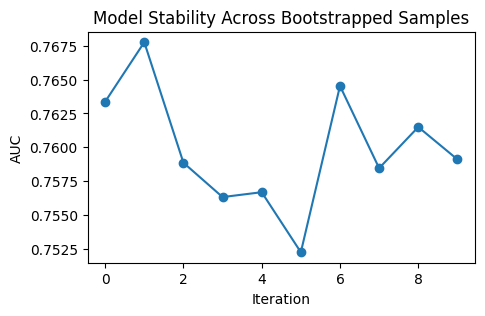

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(bootstrap_aucs, marker='o')
plt.title("Model Stability Across Bootstrapped Samples")
plt.ylabel("AUC")
plt.xlabel("Iteration")
plt.show()


In [ ]:
#SHAP vs Model Importance Comparison
compare_df = pd.DataFrame({
    "feature": X_test.columns,
    "shap_importance": np.abs(shap_values).mean(axis=0),
    "model_importance": final_model.feature_importances_
}).sort_values("shap_importance", ascending=False)

compare_df.head(10)


,feature,shap_importance,model_importance
27,TOTAL_PAY_DELAY,0.460023,0.183735
5,PAY_0,0.395208,0.193172
0,LIMIT_BAL,0.299617,0.022387
4,AGE,0.237988,0.019625
11,BILL_AMT1,0.137060,0.022758
24,TOTAL_PAY,0.133591,0.026129
17,PAY_AMT1,0.132649,0.021769
22,PAY_AMT6,0.120348,0.021499
18,PAY_AMT2,0.112950,0.020801
2,EDUCATION,0.103974,0.021230


In [ ]:
#Compare Global Importances
comp_df = pd.DataFrame({
    "feature": processed_feature_names,
    "shap_importance": mean_abs_shap,
    "model_gain_importance": best_model.feature_importances_,
    "permutation_importance": perm_df.set_index("feature").loc[processed_feature_names, "importance"].values
})

comp_df_sorted = comp_df.sort_values("shap_importance", ascending=False)
comp_df_sorted.head(15)


,feature,shap_importance,model_gain_importance,permutation_importance
27,TOTAL_PAY_DELAY,0.460023,0.183735,0.018533
5,PAY_0,0.395208,0.193172,0.030750
0,LIMIT_BAL,0.299617,0.022387,-0.002683
4,AGE,0.237988,0.019625,0.001317
11,BILL_AMT1,0.137060,0.022758,-0.000900
24,TOTAL_PAY,0.133591,0.026129,-0.004217
17,PAY_AMT1,0.132649,0.021769,-0.001750
22,PAY_AMT6,0.120348,0.021499,-0.000833
18,PAY_AMT2,0.112950,0.020801,-0.003783
2,EDUCATION,0.103974,0.021230,-0.000133


In [ ]:
!zip -r shap_outputs.zip local_plots shap_summary.png shap_bar_plot.png shap_summary_violin.png global_plots


updating: local_plots/ (stored 0%)
updating: local_plots/shap_local_4796.png (deflated 12%)
updating: local_plots/shap_local_5610.png (deflated 14%)
updating: local_plots/shap_local_5551.png (deflated 12%)
updating: local_plots/shap_local_285.png (deflated 13%)
updating: local_plots/shap_local_1201.png (deflated 14%)
updating: local_plots/shap_local_5628.png (deflated 14%)
updating: local_plots/shap_local_3487.png (deflated 14%)
updating: local_plots/shap_local_572.png (deflated 11%)
updating: local_plots/shap_local_3311.png (deflated 13%)
updating: local_plots/shap_local_3447.png (deflated 13%)
updating: shap_summary.png (deflated 5%)
updating: shap_bar_plot.png (deflated 21%)
  adding: shap_summary_violin.png (deflated 5%)
  adding: global_plots/ (stored 0%)
  adding: global_plots/shap_bar.png (deflated 26%)
  adding: global_plots/shap_summary.png (deflated 5%)


In [ ]:
!pip freeze > requirements.txt
